In [129]:
import networkx as nx 
import matplotlib.pyplot as plt
import geopandas
import matplotlib.pyplot as plt
import momepy
import networkx as nx
from contextily import add_basemap
from libpysal import weights

### Création du graphe

On lit notre geojson généré par digitalisation des routes dan Qgis. Ensuite on le convertit en un graphe tout en créant des noeuds lorsqu'il y a des intersections.

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/17/74978/60434.png

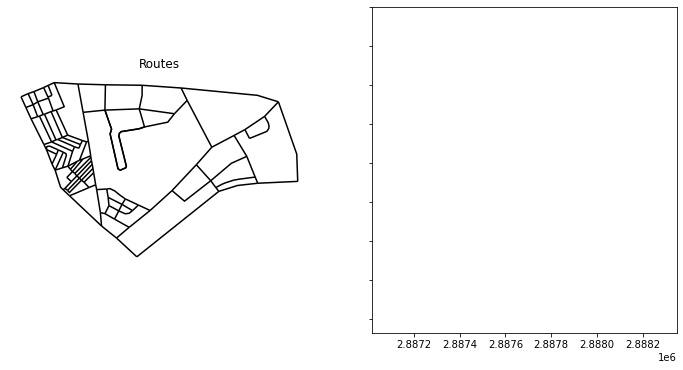

In [202]:
roads = geopandas.read_file("roads.geojson").to_crs(3035)
G = momepy.gdf_to_nx(roads, approach="primal", multigraph=False)

positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
roads.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Routes", "Graph")[i])
    facet.axis("off")

nx.draw(G, positions, ax=ax[1], node_size=5)

### Enregitrement des noeuds

On enregistre les noeuds générés sous forme de geojson

In [182]:
nodes, edges, W = momepy.nx_to_gdf(G, spatial_weights=True)
nodes = nodes.to_crs(4326)
nodes.to_file("nodes.geojson")
print(nodes)

     nodeID                   geometry
0         0  POINT (-5.81318 35.76449)
1         1  POINT (-5.81505 35.76409)
2         2  POINT (-5.82012 35.76026)
3         3  POINT (-5.82124 35.76082)
4         4  POINT (-5.82696 35.76552)
..      ...                        ...
101     101  POINT (-5.82600 35.76489)
102     102  POINT (-5.82576 35.76502)
103     103  POINT (-5.82369 35.76433)
104     104  POINT (-5.82378 35.76400)
105     105  POINT (-5.82405 35.76383)

[106 rows x 2 columns]


### Planarité

On détérmine avec cette fonction si le graphe est planaire ou pas

In [183]:
def is_planar(graph):
    return nx.check_planarity(graph)[0]

is_planar(G)

True

## Nombre de cicrcuits:

on calcule le nombre de circuits qui existe dans notre réseau

In [186]:
def number_cycles(graph):
    return len(nx.cycle_basis(graph))

number_cycles(G)

56

## Topologie

On calcule le nombre de noeuds et des liens existants


In [190]:
def topology(graph):
    return (nx.number_of_nodes(graph), nx.number_of_edges(graph))

nodes, edges = topology(G)
print("Noeuds: {} \nLiens : {}".format(nodes, edges))

Noeuds: 106 
Liens : 161


## Composantes connexes

On calcule le nombre de composantes connexes existan dans notre graphe

In [191]:
def components_count(graph):
    return nx.number_connected_components(graph)

components_count(G)

1

## Connexité

les indicateurs de connexité traduit la facilité qu’un réseau offre pour relier
deux sommet quelconques.

On calcule 2 indicateurs de connexité:
- Indicateur simple $IC_1 = \frac{S - C}{S - 1}$


- Indicateur pondéré $IC_2 = \frac{\Sigma(S_k²)}{S²}$

In [193]:
def connexity(graph, kind="weighted"):
    if kind not in ["weighted", "simple"]:
        raise ValueError("kind should be either simple or weighted")
    
    nodes_count, edges_count = topology(graph)
    if kind == "weighted":
        connected_components_nodes = [len(component)**2 for component in nx.connected_components(graph)]
        return sum(connected_components_nodes) / nodes_count**2
    
    # simple connexity
    return (nodes_count - components_count(graph)) / (nodes_count - 1)
    
print("simple : " + str(connexity(G, kind="simple")))
print("weighted : " + str(connexity(G)))

simple : 1.0
weighted : 1.0


## Connectivité

Ces indices sont basés sur la fréquence des liens ou échanges
Ils mesurent la densité et la variété des relations possibles, directes ou indirectes
entre les sommets d'un graphe.
Ils précisent les différences entre des graphes connexes (qui ont tous des indices de
connexités égaux à 100%).

On calcule 4 indices de connectivités:
- $\beta = \frac{L}{S}$. Si $\beta \geq 1$ on dit qu'il exite des circuits dans le graphe.
- $\gamma = \frac{L}{L_{max}}$
- Le nombre cyclomatique $\mu = L - S + C$
- $\alpha = \frac {\mu}{\mu_{max}}$

Avec $L_{max} = 3(S - 2)$, $ \mu_{max} = 2(S - 5)$,  dans le cas d'un graphe planaire et $L_{max} = \frac {S(S - 1)}{2}$, $\mu_{max}\frac{S(S - 1)}{2} - (S - 1)$ si le graphe n'est pas planaire.

In [194]:
def connectivity(graph, kind="alpha"):
    if kind not in ["alpha", "mu", "beta", "gamma"]:
        raise ValueError("kind should be either alpha, beta, mu or gamma")
        
    nodes_count, edges_count = topology(graph)
    
    if kind == "mu":
        return len(nx.cycle_basis(graph))
    
    if kind == "alpha":
        cycles = len(nx.cycle_basis(graph))
        
        if is_planar(graph):
            max_cycles = 2 * nodes_count - 5
        else:
            max_cycles = nodes_count * ((nodes_count - 1) / 2) - nodes_count + 1
        
        return round(cycles / max_cycles, 2)
    
    if kind == "beta":
        return round(edges_count / nodes_count, 2)
    
    if kind == "gamma":
        l_max = 3 * (nodes_count - 2) if is_planar(graph) else (nodes_count * (nodes_count - 1)) / 2
        return round(edges_count / l_max, 2)

print("Mu : " + str(connectivity(G, "mu")))
print("Alpha : " + str(connectivity(G, "alpha")))
print("Beta : " + str(connectivity(G, "beta")))
print("Gamma : " + str(connectivity(G, "gamma")))

Mu : 56
Alpha : 0.27
Beta : 1.52
Gamma : 0.52


## Centralité de degrée ou d'ordre

C’est le nombre de liaisons directes qui partent d'un point d’accès

In [195]:
def centrality_degree(graph):
    return sorted(nx.degree(graph))

centrality_degree(G)

[((2887079.5763969366, 1559802.011713958), 2),
 ((2887100.871671437, 1559755.397454131), 3),
 ((2887110.5316347494, 1559816.0568637375), 3),
 ((2887123.3623989914, 1559706.1123753788), 3),
 ((2887132.435851993, 1559767.7940775605), 4),
 ((2887135.9731415715, 1559824.836663695), 3),
 ((2887152.0485982066, 1559715.4220512877), 3),
 ((2887152.697572193, 1559780.1949575704), 4),
 ((2887159.8499835515, 1559718.1821240208), 3),
 ((2887176.384916787, 1559724.68132101), 3),
 ((2887178.2640544623, 1559842.5173799922), 3),
 ((2887179.4620559593, 1559593.7841828177), 3),
 ((2887181.9327387, 1559726.309037784), 3),
 ((2887190.594470237, 1559572.0924210849), 4),
 ((2887197.230824969, 1559801.182651739), 3),
 ((2887197.961701991, 1559851.843258065), 3),
 ((2887199.4565340905, 1559796.3726287894), 3),
 ((2887210.7529460033, 1559737.675200742), 1),
 ((2887213.082745106, 1559605.178294424), 4),
 ((2887214.6837987667, 1559808.2864073152), 2),
 ((2887214.880775663, 1559508.31709085), 3),
 ((2887219.36916

## Centralité d'éloignement moyenne des noeuds

C’est la distance moyenne entre un sommet et l'ensemble des autres sommets.

On calcule d'abord les distances des plus court chemins entre les pairs de noeuds,
et ensuite on calcule la moyenne pour chaque noeuds

In [196]:
def nodes_centralite_eloignement_moyen(graph):
    result = dict()
    
    pairs_shortest_path_length = nx.all_pairs_shortest_path_length(graph)
    
    for node, paths_length in pairs_shortest_path_length:
        result[node] = round(sum(paths_length.values()) / (len(paths_length.values()) - 1 ), 1)
    
    return result

nodes_centralite_eloignement_moyen(G)

{(2888287.6031463104, 1559432.889066195): 7.6,
 (2888112.984921865, 1559424.8218111002): 7.5,
 (2887585.175692118, 1559103.541461353): 6.9,
 (2887496.377101137, 1559185.5645889188): 6.4,
 (2887079.5763969366, 1559802.011713958): 8.4,
 (2887110.5316347494, 1559816.0568637375): 8.4,
 (2888203.3335616216, 1559780.211827004): 7.4,
 (2888142.852814935, 1559716.5480214264): 8.2,
 (2887328.103184602, 1559857.9402227593): 6.3,
 (2887350.5481586475, 1559734.3294361227): 6.0,
 (2887405.480998647, 1559418.0087870795): 6.8,
 (2887376.6304187467, 1559406.0504239143): 6.4,
 (2887214.880775663, 1559508.31709085): 6.1,
 (2887190.594470237, 1559572.0924210849): 6.5,
 (2888009.7255374426, 1559633.4903572868): 8.0,
 (2888065.2359971604, 1559542.0636994846): 8.1,
 (2887738.8232167894, 1559392.6569636273): 7.3,
 (2887907.799056274, 1559435.8035229356): 7.6,
 (2887844.9058529483, 1559505.636170154): 7.3,
 (2888101.826026663, 1559451.7649436567): 8.1,
 (2887930.0227303766, 1559405.833898464): 7.7,
 (2887778.

## Centralité d'éloignement moyenne du graphe

C'est la moyenne de centralité d'éloignement pour tout le graphe

In [197]:
def total_mean_centrality(graph):
    return round(nx.average_shortest_path_length(graph), 1)

total_mean_centrality(G)

7.1

### Centralité d'éloignement max:
C’est la distance maximale entre un sommet et l'ensemble des
autres sommets

In [198]:
def centralite_eloignement_max(graph):
    result = dict()
    shortest_paths = nx.shortest_path_length(G)
    for node, paths in shortest_paths:
        result[node] = max(paths.values())
    
    return result

centralite_eloignement_max(G)

{(2888287.6031463104, 1559432.889066195): 12,
 (2888112.984921865, 1559424.8218111002): 12,
 (2887585.175692118, 1559103.541461353): 12,
 (2887496.377101137, 1559185.5645889188): 12,
 (2887079.5763969366, 1559802.011713958): 14,
 (2887110.5316347494, 1559816.0568637375): 15,
 (2888203.3335616216, 1559780.211827004): 12,
 (2888142.852814935, 1559716.5480214264): 13,
 (2887328.103184602, 1559857.9402227593): 12,
 (2887350.5481586475, 1559734.3294361227): 11,
 (2887405.480998647, 1559418.0087870795): 12,
 (2887376.6304187467, 1559406.0504239143): 12,
 (2887214.880775663, 1559508.31709085): 12,
 (2887190.594470237, 1559572.0924210849): 13,
 (2888009.7255374426, 1559633.4903572868): 14,
 (2888065.2359971604, 1559542.0636994846): 14,
 (2887738.8232167894, 1559392.6569636273): 13,
 (2887907.799056274, 1559435.8035229356): 13,
 (2887844.9058529483, 1559505.636170154): 13,
 (2888101.826026663, 1559451.7649436567): 13,
 (2887930.0227303766, 1559405.833898464): 13,
 (2887778.3843564913, 1559840.5

## Centralité d'intermédiarité

C’est le nombre de liaisons transitant obligatoirement par un sommet.
La Centralité d’intermédiarité (CI) est aussi la capacité
d'un sommet à contrôler (faciliter, empêcher, gêner) les
relations entre d'autres sommets.

In [199]:
def max_centralite_intermediarite(graph):
    return nx.betweenness_centrality(graph, normalized=False, endpoints=False)

max_centralite_intermediarite(G)

{(2888287.6031463104, 1559432.889066195): 222.99699034625485,
 (2888112.984921865, 1559424.8218111002): 273.1314149494294,
 (2887585.175692118, 1559103.541461353): 408.4966927272074,
 (2887496.377101137, 1559185.5645889188): 793.4337787735428,
 (2887079.5763969366, 1559802.011713958): 28.80870669363317,
 (2887110.5316347494, 1559816.0568637375): 94.76908544886483,
 (2888203.3335616216, 1559780.211827004): 379.42722334854665,
 (2888142.852814935, 1559716.5480214264): 116.05119896443429,
 (2887328.103184602, 1559857.9402227593): 847.0581688328008,
 (2887350.5481586475, 1559734.3294361227): 783.6625382651116,
 (2887405.480998647, 1559418.0087870795): 303.04352935076605,
 (2887376.6304187467, 1559406.0504239143): 303.7954233030473,
 (2887214.880775663, 1559508.31709085): 624.5805888963977,
 (2887190.594470237, 1559572.0924210849): 593.2389222297311,
 (2888009.7255374426, 1559633.4903572868): 169.7948327815975,
 (2888065.2359971604, 1559542.0636994846): 98.39963924963925,
 (2887738.82321678

In [200]:
nx.density(G)

0.028930817610062894